# Information content example: compute required bits

In [1]:
%load_ext autoreload
%autoreload
import fcpy

/workspace/field-compression/miniconda3/envs/fcpy/lib/python3.10/site-packages/ecmwflibs/__init__.py:69: UserWarning: ecmwflibs: ignoring provided 'GRIB_DEFINITION_PATH' set to '/workspace/field-compression/miniconda3/envs/fcpy/lib/metview-bundle/share/metview/etc/grib_def/definitions:/workspace/field-compression/miniconda3/envs/fcpy/./share/eccodes/definitions:/tmp/mv.2243./bufr_def'. If you want ecmwflibs to use this environment variable, use ECMWFLIBS_GRIB_DEFINITION_PATH instead. If you want to use your own ECCODES library, use ECMWFLIBS_ECCODES.
  warnings.warn(


In [2]:
ds = fcpy.open_dataset("../data/cams_q_20191201_v3.nc")

ds = ds[["q"]]
ds

<xarray.Dataset>
Dimensions:  (time: 1, lev: 137, lat: 451, lon: 900)
Coordinates:
  * time     (time) datetime64[ns] 2019-12-01T12:00:00
  * lon      (lon) float64 0.0 0.4 0.8 1.2 1.6 ... 358.0 358.4 358.8 359.2 359.6
  * lat      (lat) float64 -90.0 -89.6 -89.2 -88.8 -88.4 ... 88.8 89.2 89.6 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 133.0 134.0 135.0 136.0 137.0
Data variables:
    q        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 137, 451, 900), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 15 18:37:28 2021: cdo -f nc4 copy tmp.grib data/mil...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [ ]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Float(bits=32),
    var_name="q",
    compressor=fcpy.LinQuantization(bits=24),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

In [ ]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.PCA(bits=75),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

In [ ]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.PCA(bits=100),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

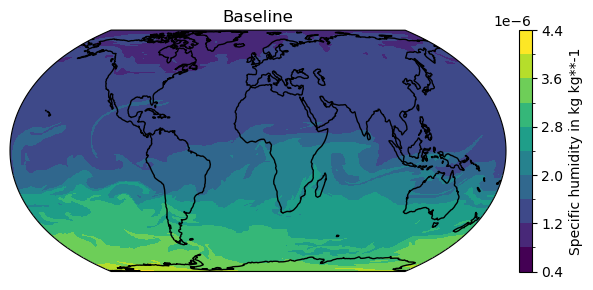

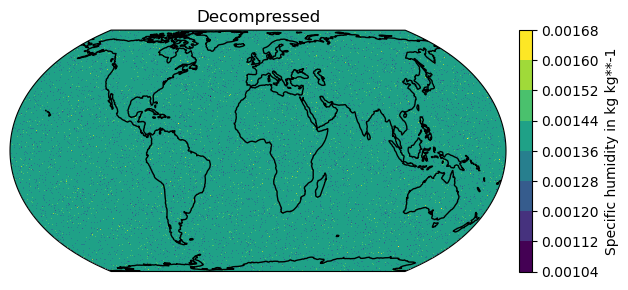

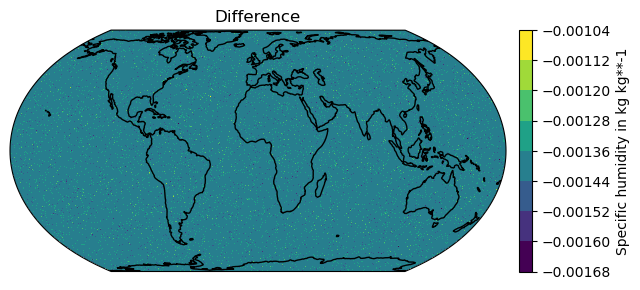

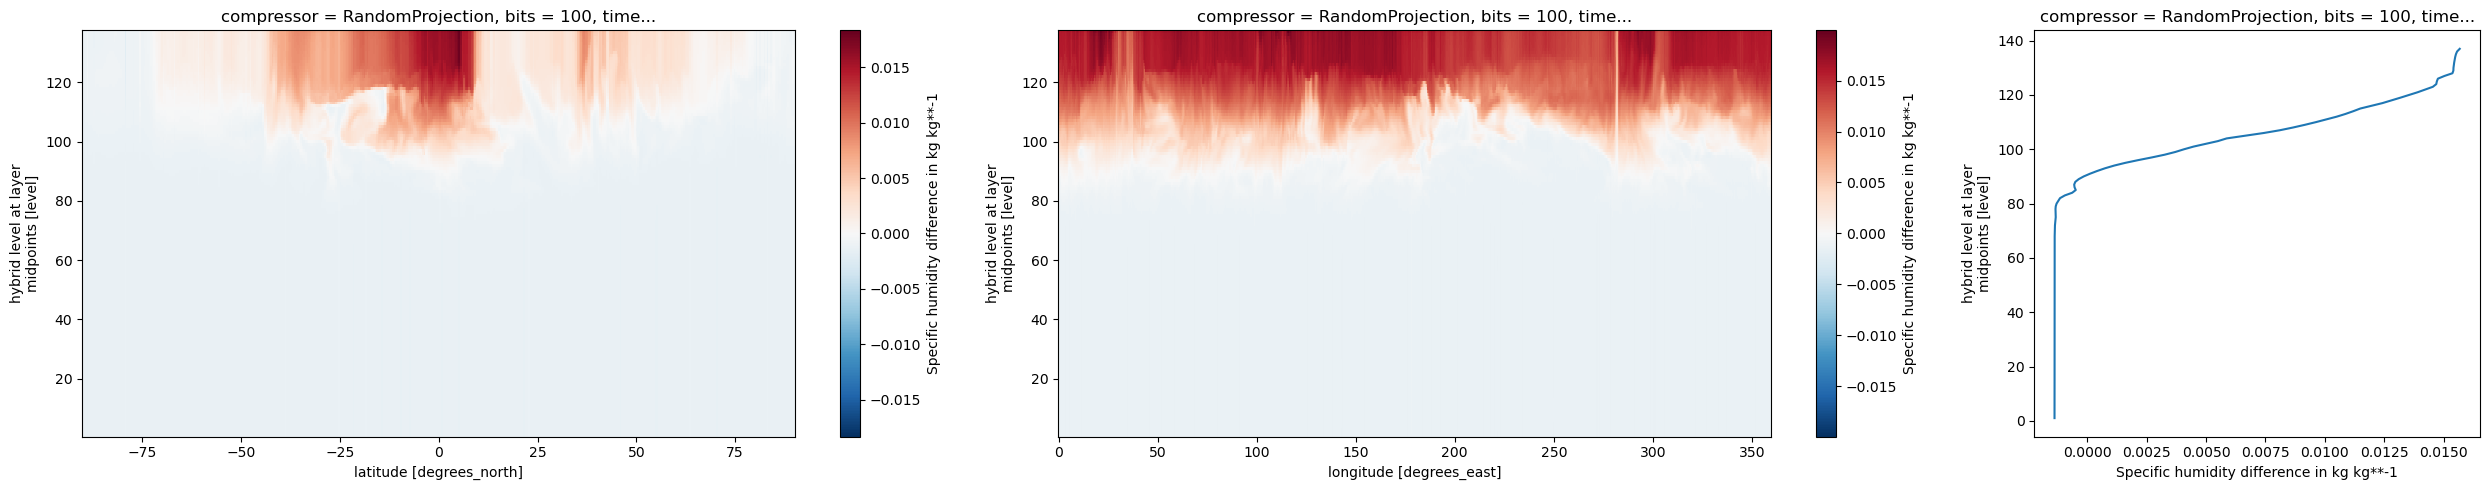

In [4]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.RandomProjection(bits=100),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)